In [1]:
import pandas as pd
df = pd.read_csv('Train.csv')
del df['id']
df.head()

,content,category
0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [2]:
from io import StringIO
col = ['category', 'content']
df = df[col]
df = df[pd.notnull(df['content'])]
df.columns = ['category', 'content']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,content,category_id
0,Kitaifa,SERIKALI imesema haitakuwa tayari kuona amani...,0
1,Biashara,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",1
2,Kitaifa,SERIKALI imetoa miezi sita kwa taasisi zote z...,0
3,michezo,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,2
4,Kitaifa,WATANZANIA wamekumbushwa kusherehekea sikukuu...,0


<Figure size 576x432 with 0 Axes>

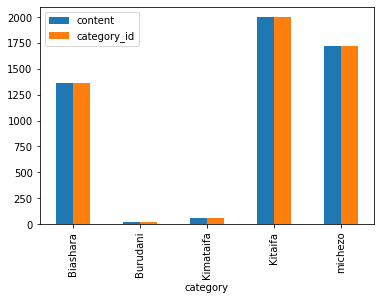

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(5151, 52264)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Biashara':
  . Most correlated unigrams:
. bidhaa
. wateja
  . Most correlated bigrams:
. soko la
. benki hiyo
# 'Burudani':
  . Most correlated unigrams:
. up
. brown
  . Most correlated bigrams:
. kumi bora
. ya urembo
# 'Kimataifa':
  . Most correlated unigrams:
. trump
. corona
  . Most correlated bigrams:
. wanandoa hao
. virusi hivyo
# 'Kitaifa':
  . Most correlated unigrams:
. timu
. mchezo
  . Most correlated bigrams:
. mchezo wa
. mchezo huo
# 'michezo':
  . Most correlated unigrams:
. timu
. mchezo
  . Most correlated bigrams:
. mchezo wa
. mchezo huo


----

Naive Bayes Classifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [7]:
print(clf.predict(count_vect.transform(["Mwenyekiti wa Chama Cha Mapinduzi (CCM) Taifa Rais John Magufuli,  amekipongeza chama hicho kwa kutimiza miaka 43 tangu kuzaliwa kwake.Katika salamu zake kupitia mtandao wa kijamii wa Twitter, Rais Magufuli ametaka wakati wa kusherehekea siku hiyo muhimu  kuendelezwa  kwa  misingi ya chama hicho na kusimamiwa kwa utekelezaji wa ilani ya CCM.Pia ametaka Wananchama wote wa CCM kudumisha amani, upendo na mshikamano.CCM ilizaliwa Februari Tano mwaka 1977 kutokana na kuungana kwa Chama cha  TANU kilichokua kikitawala Tanzania Bara na ASP kilichokua kikitawala Zanziba kwa wakati huo."])))

['Kitaifa']


----

Results

In [13]:
X_test = X_test.tolist()

In [19]:
y_pred = []

for i in X_test:
    res = clf.predict(count_vect.transform([i]))
    y_pred.append(res)

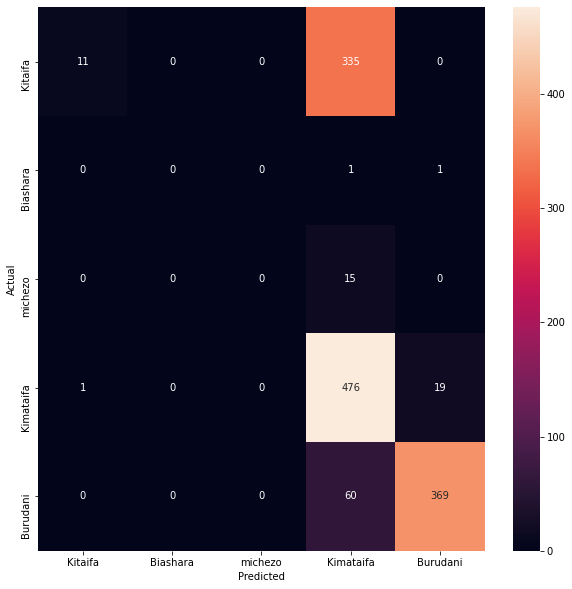

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

----

Creating Submit File(s)

In [73]:
test_df = pd.read_csv('Test.csv')

In [74]:
test_items = test_df['content'].tolist()

test_res = []

for i in test_items:
    prediction = clf.predict(count_vect.transform([i]))
    test_res.append(prediction[0])


test_df['category'] = test_res
test_df['kitaifa'], test_df['michezo'], test_df['biashara'], test_df['kimataifa'], test_df['burudani'] = [0,0,0,0,0]

In [75]:
def k_assign(x):
    if x == 'Kitaifa':
        val = 1
        return int(val)
    else:
        return 0

def m_assign(x):
    if x == 'michezo':
        val = 1
        return int(val)
    else:
        return 0

def b_assign(x):
    if x == 'Biashara':
        val = 1
        return int(val)
    else:
        return 0


In [76]:
test_df['kitaifa'] = test_df['category'].apply(lambda x: k_assign(x))
test_df['michezo'] = test_df['category'].apply(lambda x: m_assign(x))
test_df['biashara'] = test_df['category'].apply(lambda x: b_assign(x))